# We need to find out interesting points in our Loss current
because the maximum isn't always experimentally available...

**Are we in SWAN?**

In [ ]:
%pip install --user crank-nicolson-numba

**Libraries and matplotlib magic**

In [1]:
%matplotlib widget

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.integrate
from tqdm.notebook import tqdm
import crank_nicolson_numba.generic as cn
import itertools
# For parallelization
from joblib import Parallel, delayed

### Setting up the various elements for the Nekhoroshev-like diffusion

In [2]:
def D(I, I_star, exponent):
    return np.exp(-2*np.power(I_star/I, exponent))

def normed_D(I, I_star, exponent, c):
    return c * D(I, I_star, exponent)

def normed_D_half(I, I_star, exponent, c):
    return normed_D(I, I_star, exponent, c)/2

def x(I, I_max, I_star, exponent, c):
    return -scipy.integrate.quad(lambda x: 1/np.sqrt(normed_D(x, I_star, exponent, c)), I, I_max)[0]

def nu(I, I_star, exponent, c, scale=1.0):
    I = I * scale
    return (np.sqrt(c) * exponent / I) * np.power(I_star/I, exponent) * np.exp(-np.power(I_star/I, exponent))

def current_peak_time(I_0, I_max, I_star, exponent, c):
    return 2*(np.sqrt(nu(I_0, I_star, exponent, c)**2 * x(I_0, I_max, I_star, exponent, c)**2 + 9) - 3) / nu(I_0, I_star, exponent, c)**2

def current_peak_value(I_0, I_max, I_star, exponent, c):
    return -x(I_0, I_max, I_star, exponent, c)*np.exp(-nu(I_0, I_star, exponent, c)**2*(x(I_0, I_max, I_star, exponent, c) + (np.sqrt(nu(I_0, I_star, exponent, c)**2*x(I_0, I_max, I_star, exponent, c)**2 + 9) - 3)/nu(I_0, I_star, exponent, c))**2/(4*(np.sqrt(nu(I_0, I_star, exponent, c)**2*x(I_0, I_max, I_star, exponent, c)**2 + 9) - 3)))/(4*np.sqrt(np.pi)*((np.sqrt(nu(I_0, I_star, exponent, c)**2*x(I_0, I_max, I_star, exponent, c)**2 + 9) - 3)/nu(I_0, I_star, exponent, c)**2)**(3/2))

def current_point(t, I, I_max, I_star, exponent, c, scale=1.0):
    if t == 0:
        return 0.0
    return -x(I, I_max, I_star, exponent, c) / (t * np.sqrt(2*np.pi*t)) * np.exp(-(x(I, I_max, I_star, exponent, c)+((nu(I, I_star, exponent, c, scale)/2)*t))**2/(2*t))

def current_general(t, I, I_int_min, I_star, exponent, c, scale=1.0):
    return [scipy.integrate.quad(lambda x: current_point(a_t, x, I_star, exponent, c, scale), I_int_min, I)[0] for a_t in t]

In [3]:
def current_derivative(t, I, I_max, I_star, exponent, c):
    return -np.sqrt(2)*x(I, I_max, I_star, exponent, c)*(-nu(I, I_max, I_star, exponent, c)*(nu(I, I_max, I_star, exponent, c)*t/2 + x(I, I_max, I_star, exponent, c))/(2*t) + (nu(I, I_max, I_star, exponent, c)*t/2 + x(I, I_max, I_star, exponent, c))**2/(2*t**2))*np.exp(-(nu(I, I_max, I_star, exponent, c)*t/2 + x(I, I_max, I_star, exponent, c))**2/(2*t))/(2*np.sqrt(np.pi)*t**(3/2)) + 3*np.sqrt(2)*x(I, I_max, I_star, exponent, c)*np.exp(-(nu(I, I_max, I_star, exponent, c)*t/2 + x(I, I_max, I_star, exponent, c))**2/(2*t))/(4*np.sqrt(np.pi)*t**(5/2))

In [21]:
def current_second_derivative(t, I, I_max, I_star, exponent, c):
    return np.sqrt(2)*x(I, I_max, I_star, exponent, c)*(-nu(I, I_max, I_star, exponent, c)**4*t**4 - 24*nu(I, I_max, I_star, exponent, c)**2*t**3 + 8*nu(I, I_max, I_star, exponent, c)**2*t**2*x(I, I_max, I_star, exponent, c)**2 - 240*t**2 + 160*t*x(I, I_max, I_star, exponent, c)**2 - 16*x(I, I_max, I_star, exponent, c)**4)*np.exp(-nu(I, I_max, I_star, exponent, c)**2*t/8 - nu(I, I_max, I_star, exponent, c)*x(I, I_max, I_star, exponent, c)/2 - x(I, I_max, I_star, exponent, c)**2/(2*t))/(128*np.sqrt(np.pi)*t**(11/2))

## Let's check things

In [22]:
I_star = 21.5
kappa = 0.33
exponent = 1 / (2*kappa)
I_min = 0.0

In [35]:
I_0 = 4.4
I_max = 5.0
c = 1/scipy.integrate.quad(lambda x: D(x, I_star, exponent), I_min, I_max)[0]

In [65]:
T = 0.5
samples = 2500
t_list = np.linspace(0, T, samples+1)[1:]

In [66]:
current = np.array([current_point(t, I_0, I_max, I_star, exponent, c) for t in t_list])
d_current = np.array([current_derivative(t, I_0, I_max, I_star, exponent, c) for t in t_list])
d2_current = np.array([current_second_derivative(t, I_0, I_max, I_star, exponent, c) for t in t_list])

In [67]:
def align_yaxis(ax1, ax2):
    """Align zeros of the two axes, zooming them out by same ratio"""
    axes = (ax1, ax2)
    extrema = [ax.get_ylim() for ax in axes]
    tops = [extr[1] / (extr[1] - extr[0]) for extr in extrema]
    # Ensure that plots (intervals) are ordered bottom to top:
    if tops[0] > tops[1]:
        axes, extrema, tops = [list(reversed(l)) for l in (axes, extrema, tops)]

    # How much would the plot overflow if we kept current zoom levels?
    tot_span = tops[1] + 1 - tops[0]

    b_new_t = extrema[0][0] + tot_span * (extrema[0][1] - extrema[0][0])
    t_new_b = extrema[1][1] - tot_span * (extrema[1][1] - extrema[1][0])
    axes[0].set_ylim(extrema[0][0], b_new_t)
    axes[1].set_ylim(t_new_b, extrema[1][1])

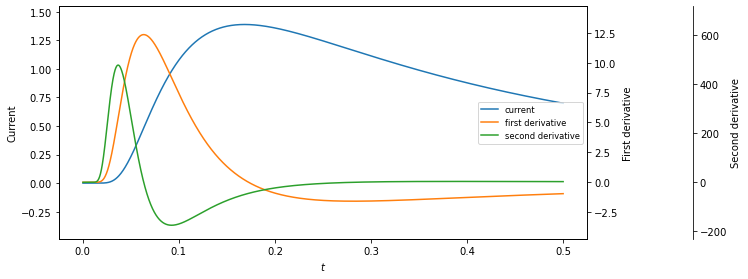

In [68]:
fig, ax1 = plt.subplots(figsize=(10,4))

ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax1.set_xlabel("$t$")

l1 = ax1.plot(t_list, current, c="C0", label="current")
l2 = ax2.plot(t_list, d_current, c="C1", label="first derivative")
l3 = ax3.plot(t_list, d2_current, c="C2", label="second derivative")

l = l1 + l2 + l3
lab = [i.get_label() for i in l]

ax1.legend(l, lab, loc="center right", fontsize="small")

ax1.set_ylabel("Current")
ax2.set_ylabel("First derivative")
ax3.set_ylabel("Second derivative")

plt.tight_layout()
fig.subplots_adjust(right=0.80)
ax3.spines["right"].set_position(("axes", 1.2))

align_yaxis(ax1, ax2)
align_yaxis(ax1, ax3)
align_yaxis(ax2, ax3)
align_yaxis(ax1, ax2)
align_yaxis(ax1, ax3)
align_yaxis(ax2, ax3)


## Points of interest
1. Current peak
    * pros: we have its perfect analytic expression
    * cons: we might not have it in a proper form in a real experiment
2. First current read
    * pros: experimentally, it might be an actual measureable feature
    * cons: we have to define numerically what "first current read" actually means
3. Maximum in first derivative (zero in second derivative)
    * pros: we can (numerically) find it in a fast and practical way; it might be a strong measure for outward steps in collimators
    * cons: it might be not stable at all when considering noisy measures
4. Percentage gain in current (i.e. timing at which we have 10% of the maximum current)
    * pros: it's basically (2), but more generic and consistently defined
    * cons: will we have actual zero currents and peak currents in an experimental setting?

## Let's make it noisy

We make the signal dirty with a background noise + offset setup

In [71]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [81]:
background_sigma = 0.05 * np.max(current)
offset = 0.01 * np.max(current)

dirty_current = np.random.normal(loc=0.0, scale=background_sigma, size=current.size) + current + offset

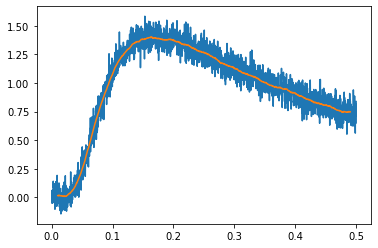

In [82]:
plt.figure()
plt.plot(t_list, dirty_current)

kernel = 100
plt.plot(t_list[kernel//2:-kernel//2+1], moving_average(dirty_current, kernel))

#plt.plot(t_list, current)
